Copyright (c) 2024 Microsoft Corporation.

Licensed under the MIT License

Experimenting with `EuroSAT` dataset under 11 settings:
- Semantic Shift: Leave-one-class-out. Train on 9 class and test on 10 class 
- Covariate Shift: Longitude-wise split. Train on West and test on East 

For each, we perform: 
- activation extraction
- downsample benchmarking
- layer benchmarking
- `g` training and evaluation
- `g_hat` training and evaluation
- `g` and `g_hat` statistical significance test
- `g` benchmark
- clustering benchmark
- num_cluster vs. `g` and `g_hat` performance investigation
- activation space visualization    

In [1]:
import os
import sys

import torch

sys.path.append("..")
from src.tardis.eurosat_xbd_utils import *
from src.tardis.utils import *

print("CUDA available:", torch.cuda.is_available())
print("Number of GPUs:", torch.cuda.device_count())
print("Current GPU:", torch.cuda.current_device())
print("GPU Name:", torch.cuda.get_device_name(0))

%load_ext autoreload
%autoreload 2

fixed_seed = 31
set_seed(fixed_seed)

CUDA available: True
Number of GPUs: 2
Current GPU: 0
GPU Name: NVIDIA A100 80GB PCIe


In [2]:
# Define main directories for checkpoints and configs
ckpt_main_dir = "/data/dataood/exp_data/main_tardis/eurosat_exp_logs"
config_main_dir = "/ws/geospatial-ood-detection/configs"

# Define a function to construct the paths dynamically
def construct_paths(main_dir, sub_dir, filename):
    return os.path.join(main_dir, sub_dir, filename)

# Define subdirectories and filenames for each configuration and checkpoint
paths = {
    "forest": {
        "config": construct_paths(
            config_main_dir, "eurosat", "eurosat_holdout_Forest.yaml"
        ),
        "ckpt": construct_paths(
            ckpt_main_dir, "Holdout_Forest_resnet50_0066", "epoch=21-step=4972.ckpt"
        ),
    },
    "herb_veg": {
        "config": construct_paths(
            config_main_dir, "eurosat", "eurosat_holdout_HerbaceousVegetation.yaml"
        ),
        "ckpt": construct_paths(
            ckpt_main_dir,
            "Holdout_HerbaceousVegetation_resnet50_0066",
            "epoch=27-step=6328.ckpt",
        ),
    },
    "highway": {
        "config": construct_paths(
            config_main_dir, "eurosat", "eurosat_holdout_Highway.yaml"
        ),
        "ckpt": construct_paths(
            ckpt_main_dir, "Holdout_Highway_resnet50_0066", "epoch=28-step=6670.ckpt"
        ),
    },
    "industrial": {
        "config": construct_paths(
            config_main_dir, "eurosat", "eurosat_holdout_Industrial.yaml"
        ),
        "ckpt": construct_paths(
            ckpt_main_dir, "Holdout_Industrial_resnet50_0066", "epoch=32-step=7590.ckpt"
        ),
    },
    "pasture": {
        "config": construct_paths(
            config_main_dir, "eurosat", "eurosat_holdout_Pasture.yaml"
        ),
        "ckpt": construct_paths(
            ckpt_main_dir, "Holdout_Pasture_resnet50_0066", "epoch=34-step=8225.ckpt"
        ),
    },
    "permanentcrop": {
        "config": construct_paths(
            config_main_dir, "eurosat", "eurosat_holdout_PermanentCrop.yaml"
        ),
        "ckpt": construct_paths(
            ckpt_main_dir,
            "Holdout_PermanentCrop_resnet50_0066",
            "epoch=26-step=6210.ckpt",
        ),
    },
    "residential": {
        "config": construct_paths(
            config_main_dir, "eurosat", "eurosat_holdout_Residential.yaml"
        ),
        "ckpt": construct_paths(
            ckpt_main_dir,
            "Holdout_Residential_resnet50_0066",
            "epoch=49-step=11250.ckpt",
        ),
    },
    "river": {
        "config": construct_paths(
            config_main_dir, "eurosat", "eurosat_holdout_River.yaml"
        ),
        "ckpt": construct_paths(
            ckpt_main_dir, "Holdout_River_resnet50_0066", "epoch=31-step=7392.ckpt"
        ),
    },
    "sealake": {
        "config": construct_paths(
            config_main_dir, "eurosat", "eurosat_holdout_SeaLake.yaml"
        ),
        "ckpt": construct_paths(
            ckpt_main_dir, "Holdout_SeaLake_resnet50_0066", "epoch=34-step=7875.ckpt"
        ),
    },
    "annualcrop": {
        "config": construct_paths(
            config_main_dir, "eurosat", "eurosat_holdout_AnnualCrop.yaml"
        ),
        "ckpt": construct_paths(
            ckpt_main_dir, "Holdout_AnnualCrop_resnet50_0066", "epoch=15-step=3616.ckpt"
        ),
    },
    "spatial_split": {
        "config": construct_paths(
            config_main_dir, "eurosat", "eurosat_Spatial.yaml"
        ),
        "ckpt": construct_paths(
            ckpt_main_dir, "eurosat_spatial_0776", "epoch=18-step=4826.ckpt"
        ),
    },
}

# Define other parameters
layer = ["conv1"]
downsample_method = "max_pool"
getitem_keys = ["image", "label"]
n_batches_to_process = 2 # Set to ´None´ to process all the samples
device = "cuda" if torch.cuda.is_available() else "cpu"

# Downsampling methods and benchmarks
downsample_methods = ["avg_pool", "mean_std", "avg_pool", "max_pool", "nodownsample"]
downsample_benchmark = {}
layer_benchmark = {}

verbose = False
test_size = 0.2
n_estimators = 100
split_seed = 31
fixed_classifier_seed = 31

n_optuna_trials = 20
min_cluster = 2
max_cluster_ratio = 0.3
min_fraction = 0.01
max_fraction = 0.2
fixed_seed = 31

# Print paths to verify
for key, path in paths.items():
    print(f"{key} config path: {path['config']}")
    print(f"{key} ckpt path: {path['ckpt']}")

forest config path: /ws/geospatial-ood-detection/configs/eurosat/eurosat_holdout_Forest.yaml
forest ckpt path: /data/dataood/exp_data/main_tardis/eurosat_exp_logs/Holdout_Forest_resnet50_0066/epoch=21-step=4972.ckpt
herb_veg config path: /ws/geospatial-ood-detection/configs/eurosat/eurosat_holdout_HerbaceousVegetation.yaml
herb_veg ckpt path: /data/dataood/exp_data/main_tardis/eurosat_exp_logs/Holdout_HerbaceousVegetation_resnet50_0066/epoch=27-step=6328.ckpt
highway config path: /ws/geospatial-ood-detection/configs/eurosat/eurosat_holdout_Highway.yaml
highway ckpt path: /data/dataood/exp_data/main_tardis/eurosat_exp_logs/Holdout_Highway_resnet50_0066/epoch=28-step=6670.ckpt
industrial config path: /ws/geospatial-ood-detection/configs/eurosat/eurosat_holdout_Industrial.yaml
industrial ckpt path: /data/dataood/exp_data/main_tardis/eurosat_exp_logs/Holdout_Industrial_resnet50_0066/epoch=32-step=7590.ckpt
pasture config path: /ws/geospatial-ood-detection/configs/eurosat/eurosat_holdout_Pa

# Spatial Split

### Start

In [3]:
X,y,model,datamodule,train_dataloader,val_dataloader,test_dataloader,cfg_dict = get_X_y_arrays(
        paths["spatial_split"]["config"],
        paths["spatial_split"]["ckpt"],
        layer,
        downsample_method,
        getitem_keys,
        device,
        n_batches_to_process,
        mode="spatialsplit",
        verbose=False,
    )

/opt/conda/envs/ood/lib/python3.11/site-packages/lightning/pytorch/utilities/migration/utils.py:56: The loaded checkpoint was produced with Lightning v2.4.0, which is newer than your current Lightning version: v2.2.5
INFO:torch.distributed.nn.jit.instantiator:Created a temporary directory at /tmp/tmps42w84vl
INFO:torch.distributed.nn.jit.instantiator:Writing /tmp/tmps42w84vl/_remote_module_non_scriptable.py


Model and Task are loaded.
('B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B09', 'B10', 'B11', 'B12')
DataModule setup complete.
Model -- Task -- Dataloaders are loaded.
len(train_dataloader), len(val_dataloader), len(test_dataloader):  254 85 85


100%|██████████| 2/2 [00:01<00:00,  1.26it/s]


Before downsampling, activations shape for layer conv1 : (128, 64, 32, 32)


100%|██████████| 2/2 [00:00<00:00,  5.69it/s]


Before downsampling, activations shape for layer conv1 : (128, 64, 32, 32)


### Downsample Benchmark

In [4]:
all_layer_names = get_all_layer_names(model)

conv_layers = [layer for layer in all_layer_names if "conv" in layer]
selected_layers = pick_random_layers(all_layer_names, 10)
selected_layers = [[layer] for layer in selected_layers]

In [5]:
for downsample in downsample_methods:
    print(f"Running experiments for {downsample} downsample method.")
    X, y, test_property_lengths = create_feature_matrix_and_labels(
        model=model,
        dm=datamodule,
        train_dataloader=train_dataloader,
        test_dataloader=test_dataloader,
        layer_names=layer,
        device=device,
        getitem_keys=getitem_keys,
        n_batches_to_process=n_batches_to_process,
        downsample_method=downsample,
        verbose=verbose,
    )
    print("Run g experiment for downsample method:", downsample)
    g_benchmark = run_g_experiment(
        X, y, split_seed, test_size, n_estimators, fixed_classifier_seed, clf=None
    )
    downsample_benchmark[downsample] = g_benchmark

Running experiments for avg_pool downsample method.


100%|██████████| 2/2 [00:00<00:00,  5.34it/s]


Before downsampling, activations shape for layer conv1 : (128, 64, 32, 32)


100%|██████████| 2/2 [00:00<00:00,  5.39it/s]


Before downsampling, activations shape for layer conv1 : (128, 64, 32, 32)
Run g experiment for downsample method: avg_pool
Running experiments for mean_std downsample method.


100%|██████████| 2/2 [00:00<00:00,  5.29it/s]


Before downsampling, activations shape for layer conv1 : (128, 64, 32, 32)


100%|██████████| 2/2 [00:00<00:00,  5.42it/s]


Before downsampling, activations shape for layer conv1 : (128, 64, 32, 32)
Run g experiment for downsample method: mean_std
Running experiments for avg_pool downsample method.


100%|██████████| 2/2 [00:00<00:00,  5.51it/s]


Before downsampling, activations shape for layer conv1 : (128, 64, 32, 32)


100%|██████████| 2/2 [00:00<00:00,  5.32it/s]


Before downsampling, activations shape for layer conv1 : (128, 64, 32, 32)
Run g experiment for downsample method: avg_pool
Running experiments for max_pool downsample method.


100%|██████████| 2/2 [00:00<00:00,  5.83it/s]


Before downsampling, activations shape for layer conv1 : (128, 64, 32, 32)


100%|██████████| 2/2 [00:00<00:00,  5.19it/s]


Before downsampling, activations shape for layer conv1 : (128, 64, 32, 32)
Run g experiment for downsample method: max_pool
Running experiments for nodownsample downsample method.


100%|██████████| 2/2 [00:00<00:00,  5.69it/s]


Before downsampling, activations shape for layer conv1 : (128, 64, 32, 32)


100%|██████████| 2/2 [00:00<00:00,  5.33it/s]


Before downsampling, activations shape for layer conv1 : (128, 64, 32, 32)
Run g experiment for downsample method: nodownsample


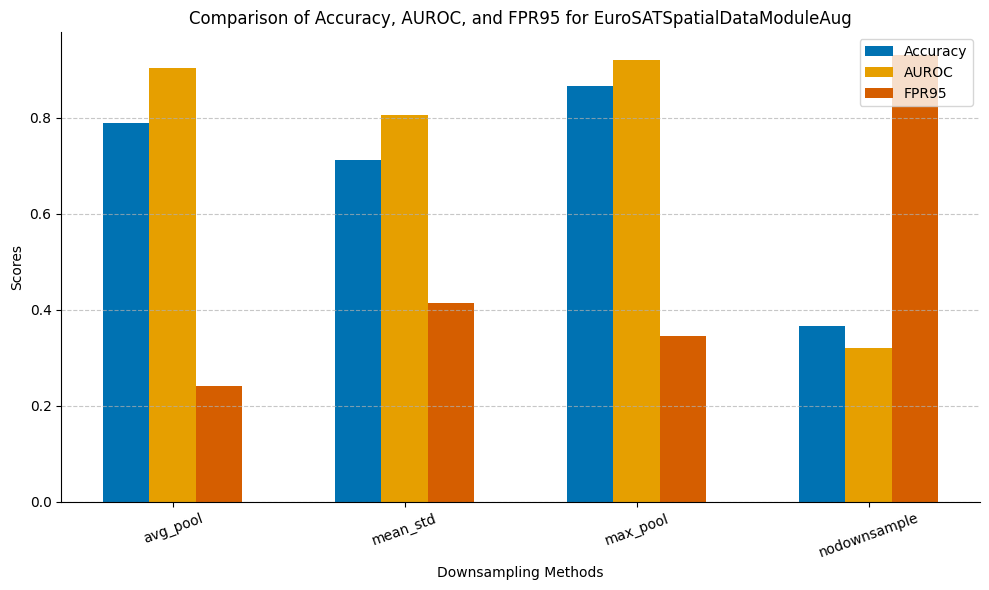

In [6]:
plot_downsample_benchmark(downsample_benchmark, datamodule.__class__.__name__)

### Layer Benchmark

In [7]:
for lyr in selected_layers:
    print(f"Running experiments for layer {lyr}")
    X, y, test_property_lengths = create_feature_matrix_and_labels(
        model=model,
        dm=datamodule,
        train_dataloader=train_dataloader,
        test_dataloader=test_dataloader,
        layer_names=lyr,
        device=device,
        getitem_keys=getitem_keys,
        n_batches_to_process=n_batches_to_process,
        downsample_method=downsample_method,
        verbose=verbose,
    )

    g_benchmark = run_g_experiment(
        X, y, split_seed, test_size, n_estimators, fixed_classifier_seed, clf=None
    )

    layer_benchmark[str(lyr)] = g_benchmark

Running experiments for layer ['conv1']


100%|██████████| 2/2 [00:00<00:00,  5.33it/s]


Before downsampling, activations shape for layer conv1 : (128, 64, 32, 32)


100%|██████████| 2/2 [00:00<00:00,  5.35it/s]


Before downsampling, activations shape for layer conv1 : (128, 64, 32, 32)
Running experiments for layer ['layer1.0.conv1']


100%|██████████| 2/2 [00:00<00:00,  5.69it/s]


Before downsampling, activations shape for layer layer1.0.conv1 : (128, 64, 16, 16)


100%|██████████| 2/2 [00:00<00:00,  5.39it/s]


Before downsampling, activations shape for layer layer1.0.conv1 : (128, 64, 16, 16)
Running experiments for layer ['layer3.3.conv1']


100%|██████████| 2/2 [00:00<00:00,  5.94it/s]


Before downsampling, activations shape for layer layer3.3.conv1 : (128, 256, 4, 4)


100%|██████████| 2/2 [00:00<00:00,  5.70it/s]


Before downsampling, activations shape for layer layer3.3.conv1 : (128, 256, 4, 4)
Running experiments for layer ['layer1.2.conv2']


100%|██████████| 2/2 [00:00<00:00,  5.54it/s]


Before downsampling, activations shape for layer layer1.2.conv2 : (128, 64, 16, 16)


100%|██████████| 2/2 [00:00<00:00,  5.63it/s]


Before downsampling, activations shape for layer layer1.2.conv2 : (128, 64, 16, 16)
Running experiments for layer ['layer3.1.conv2']


100%|██████████| 2/2 [00:00<00:00,  6.02it/s]


Before downsampling, activations shape for layer layer3.1.conv2 : (128, 256, 4, 4)


100%|██████████| 2/2 [00:00<00:00,  4.65it/s]


Before downsampling, activations shape for layer layer3.1.conv2 : (128, 256, 4, 4)
Running experiments for layer ['layer2.0.conv1']


100%|██████████| 2/2 [00:00<00:00,  5.55it/s]


Before downsampling, activations shape for layer layer2.0.conv1 : (128, 128, 16, 16)


100%|██████████| 2/2 [00:00<00:00,  5.36it/s]


Before downsampling, activations shape for layer layer2.0.conv1 : (128, 128, 16, 16)
Running experiments for layer ['layer1.0.conv3']


100%|██████████| 2/2 [00:00<00:00,  5.32it/s]


Before downsampling, activations shape for layer layer1.0.conv3 : (128, 256, 16, 16)


100%|██████████| 2/2 [00:00<00:00,  5.16it/s]


Before downsampling, activations shape for layer layer1.0.conv3 : (128, 256, 16, 16)
Running experiments for layer ['layer1.2.conv3']


100%|██████████| 2/2 [00:00<00:00,  5.47it/s]


Before downsampling, activations shape for layer layer1.2.conv3 : (128, 256, 16, 16)


100%|██████████| 2/2 [00:00<00:00,  5.18it/s]


Before downsampling, activations shape for layer layer1.2.conv3 : (128, 256, 16, 16)
Running experiments for layer ['layer4.1.conv3']


100%|██████████| 2/2 [00:00<00:00,  5.65it/s]


Before downsampling, activations shape for layer layer4.1.conv3 : (128, 2048, 2, 2)


100%|██████████| 2/2 [00:00<00:00,  5.63it/s]


Before downsampling, activations shape for layer layer4.1.conv3 : (128, 2048, 2, 2)
Running experiments for layer ['layer4.2.conv3']


100%|██████████| 2/2 [00:00<00:00,  5.71it/s]


Before downsampling, activations shape for layer layer4.2.conv3 : (128, 2048, 2, 2)


100%|██████████| 2/2 [00:00<00:00,  4.83it/s]


Before downsampling, activations shape for layer layer4.2.conv3 : (128, 2048, 2, 2)


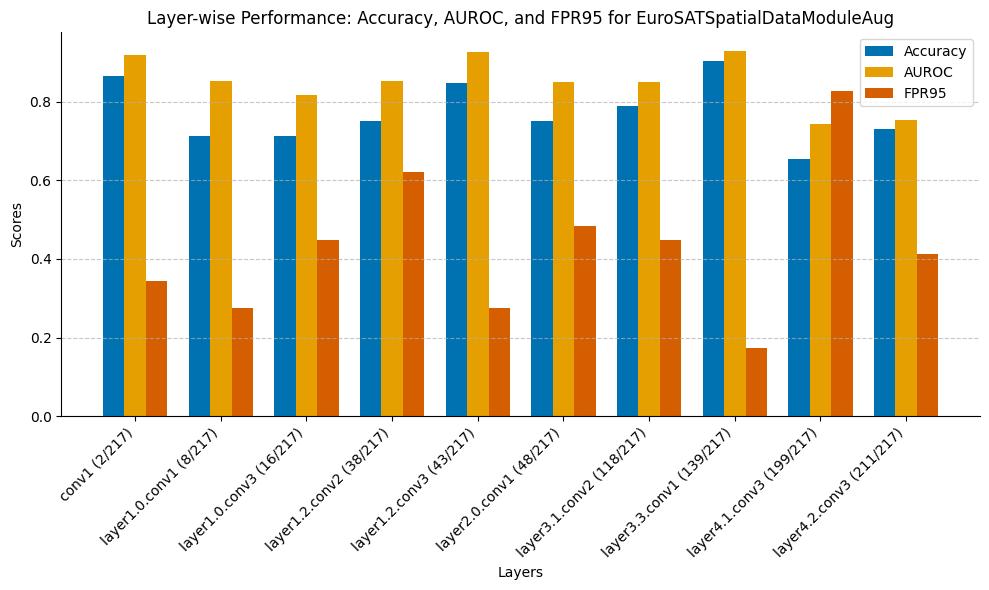

In [8]:
plot_layer_benchmark(layer_benchmark, all_layer_names, datamodule.__class__.__name__)

### g confidence interval

In [9]:
g_benchmark = run_multiple_experiments_g(
    X, y, test_size, n_estimators, random_seed=True
)

random_state for split_seed: 7250
random_state for split_seed: 1392
random_state for split_seed: 878
random_state for split_seed: 3916
random_state for split_seed: 751
random_state for split_seed: 2170
random_state for split_seed: 4239
random_state for split_seed: 2395
random_state for split_seed: 7814
random_state for split_seed: 3302


In [10]:
columns_of_interest = ["baseline_accuracy", "baseline_fpr95", "baseline_roc_auc"]
confidence_intervals_g = calculate_confidence_intervals(
    g_benchmark, columns_of_interest
)
confidence_intervals_g

{'baseline_accuracy': (0.7019230769230769, 0.03958004760027288),
 'baseline_fpr95': (0.7677337759691584, 0.12631033892481383),
 'baseline_roc_auc': (0.7328573620229427, 0.04148196023657855)}

### g_hat

In [11]:
results_df_g_hat = run_optuna_study(
    X,
    y,
    n_optuna_trials,
    test_size,
    min_cluster,
    max_cluster_ratio,
    min_fraction,
    max_fraction,
    n_estimators,
    fixed_seed,
)

[I 2024-12-22 19:55:11,735] A new study created in memory with name: no-name-bf1921d4-8440-43ed-a350-7591f6d6a95f
[I 2024-12-22 19:55:11,931] Trial 0 finished with value: inf and parameters: {'k': 19, 'M': 0.19204005763861}. Best is trial 0 with value: inf.
[I 2024-12-22 19:55:12,152] Trial 1 finished with value: -0.7059293950570866 and parameters: {'k': 48, 'M': 0.19750530058756796}. Best is trial 1 with value: -0.7059293950570866.
[I 2024-12-22 19:55:12,218] Trial 2 finished with value: inf and parameters: {'k': 14, 'M': 0.03601423928032735}. Best is trial 1 with value: -0.7059293950570866.
[I 2024-12-22 19:55:12,376] Trial 3 finished with value: -0.7513793186829935 and parameters: {'k': 56, 'M': 0.023041318415652854}. Best is trial 3 with value: -0.7513793186829935.
[I 2024-12-22 19:55:12,418] Trial 4 finished with value: inf and parameters: {'k': 6, 'M': 0.11327159100258942}. Best is trial 3 with value: -0.7513793186829935.
[I 2024-12-22 19:55:12,502] Trial 5 finished with value: i

In [13]:
N = 10
results_dict = results_df_g_hat.to_dict(orient="records")
k = int(len(X) * 0.3)
M = results_dict[0]["M"]
print("k, M, len(X), k/len(X)", k, M, len(X), k / len(X))

g_hat_benchmark = run_multiple_experiments_g_hat(X, y, test_size, k, M, N, fixed_seed)

k, M, len(X), k/len(X) 76 0.12942942912679828 256 0.296875
random_state for split_seed in iteration 1: 9646
random_state for split_seed in iteration 2: 8373
random_state for split_seed in iteration 3: 3206
random_state for split_seed in iteration 4: 6724
random_state for split_seed in iteration 5: 1050
random_state for split_seed in iteration 6: 6989
random_state for split_seed in iteration 7: 1345
random_state for split_seed in iteration 8: 5685
random_state for split_seed in iteration 9: 6101
random_state for split_seed in iteration 10: 285


### g g_hat mean std + ttest

In [14]:
t_tests_results = perform_benchmark_analysis(g_benchmark, g_hat_benchmark)
t_tests_results

Baseline Accuracy: Mean = 0.7019230769230769, Std Dev = 0.055329091351384835
Baseline ROC AUC: Mean = 0.7328573620229427, Std Dev = 0.05798778188807292
Baseline FPR95: Mean = 0.7677337759691584, Std Dev = 0.1765696785303316
g_hat Accuracy: Mean = 0.5038461538461538, Std Dev = 0.06951508570115876
g_hat ROC AUC: Mean = 0.556832160105914, Std Dev = 0.06292132902719601
g_hat FPR95: Mean = 0.8776632239435838, Std Dev = 0.06643533665828118
Accuracy: t = 7.0500922053624535, p = 1.4117378573993409e-06
ROC AUC: t = 6.505333760522647, p = 4.071393881677243e-06
FPR95: t = -1.8426674739311157, p = 0.08191121054970396


{'accuracy': (7.0500922053624535, 1.4117378573993409e-06),
 'roc_auc': (6.505333760522647, 4.071393881677243e-06),
 'fpr95': (-1.8426674739311157, 0.08191121054970396)}

### Benchmark g

In [15]:
classifier_benchmark_df = benchmark_classifiers(
    X, y, test_size, k, M, classifiers, fixed_seed
)

classifier_benchmark_df

,Classifier,Accuracy,ROC_AUC,FPR95,Number of Train Samples,Number of Val Samples,Cluster Fit Time (s),Classifier Fit Time (s),Classifier Fit Time (s/sample),Classifier Pred Time (s),Classifier Pred Time (s/sample)
0,RandomForestUnblanaced,0.557692,0.284108,1.000000,204,52,0.117748,0.410377,0.002012,0.004087,0.000079
1,RandomForest,0.557692,0.257121,1.000000,204,52,0.117748,0.265458,0.001301,0.004056,0.000078
2,SVC,0.538462,0.329835,0.965517,204,52,0.117748,0.075750,0.000371,0.006214,0.000120
3,KNeighbors,0.538462,0.332084,1.000000,204,52,0.117748,0.002923,0.000014,0.267609,0.005146
4,LogisticRegression,0.500000,0.437781,0.896552,204,52,0.117748,0.030974,0.000152,0.000603,0.000012
5,DecisionTree,0.576923,0.530735,1.000000,204,52,0.117748,0.137856,0.000676,0.000521,0.000010
6,GradientBoosting,0.480769,0.341829,1.000000,204,52,0.117748,10.132374,0.049668,0.000873,0.000017
7,AdaBoost,0.557692,0.449775,1.000000,204,52,0.117748,2.143090,0.010505,0.007855,0.000151
8,ExtraTrees,0.557692,0.244378,1.000000,204,52,0.117748,0.141492,0.000694,0.004297,0.000083
9,GaussianNB,0.403846,0.226387,0.965517,204,52,0.117748,0.003944,0.000019,0.001010,0.000019


### Benchmark clustering

In [16]:
# A fixed classifier
classifier = classifiers['RandomForest']

clustering_benchmark_df = benchmark_clustering_methods(
    X, y, test_size, k, M, clustering_methods, classifier
)

clustering_benchmark_df

,Clustering,Accuracy,ROC_AUC,FPR95,Clustering Time (s),Classifier Training Time (s),Number of Samples
0,KMeans,0.461538,0.5,1.0,0.032892,0.104989,204
1,DBSCAN_eps_0.1,0.538462,0.5,1.0,0.220328,0.097503,204
2,DBSCAN_eps_0.2,0.538462,0.5,1.0,0.232174,0.102082,204
3,DBSCAN_eps_0.5,0.538462,0.5,1.0,0.230623,0.097703,204


### Investigate k wrt g-g_hat

confidence_intervals_g {'baseline_accuracy': (0.7019230769230769, 0.03958004760027288), 'baseline_fpr95': (0.7677337759691584, 0.12631033892481383), 'baseline_roc_auc': (0.7328573620229427, 0.04148196023657855)}
Max i: 7
k: 1
Skipping k=1 on run 1 due to single class in y_clusters.
Skipping k=1 on run 2 due to single class in y_clusters.
Skipping k=1 on run 3 due to single class in y_clusters.
Skipping k=1 on run 4 due to single class in y_clusters.
Skipping k=1 on run 5 due to single class in y_clusters.
Skipping k=1 on run 6 due to single class in y_clusters.
Skipping k=1 on run 7 due to single class in y_clusters.
Skipping k=1 on run 8 due to single class in y_clusters.
Skipping k=1 on run 9 due to single class in y_clusters.
Skipping k=1 on run 10 due to single class in y_clusters.
k: 2
Skipping k=2 on run 1 due to single class in y_clusters.
Skipping k=2 on run 2 due to single class in y_clusters.
Skipping k=2 on run 3 due to single class in y_clusters.


/ws/geospatial-ood-detection/notebooks/../src/tardis/eurosat_xbd_utils.py:989: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(values)
/ws/geospatial-ood-detection/notebooks/../src/tardis/eurosat_xbd_utils.py:990: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  sem = stats.sem(values, nan_policy="omit")


Skipping k=2 on run 4 due to single class in y_clusters.
Skipping k=2 on run 5 due to single class in y_clusters.
Skipping k=2 on run 6 due to single class in y_clusters.
Skipping k=2 on run 7 due to single class in y_clusters.
Skipping k=2 on run 8 due to single class in y_clusters.
Skipping k=2 on run 9 due to single class in y_clusters.
Skipping k=2 on run 10 due to single class in y_clusters.
k: 4


/ws/geospatial-ood-detection/notebooks/../src/tardis/eurosat_xbd_utils.py:989: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(values)
/ws/geospatial-ood-detection/notebooks/../src/tardis/eurosat_xbd_utils.py:990: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  sem = stats.sem(values, nan_policy="omit")


Skipping k=4 on run 1 due to single class in y_clusters.
Skipping k=4 on run 2 due to single class in y_clusters.
Skipping k=4 on run 3 due to single class in y_clusters.
Skipping k=4 on run 4 due to single class in y_clusters.
Skipping k=4 on run 5 due to single class in y_clusters.
Skipping k=4 on run 6 due to single class in y_clusters.
Skipping k=4 on run 7 due to single class in y_clusters.
Skipping k=4 on run 8 due to single class in y_clusters.
Skipping k=4 on run 9 due to single class in y_clusters.
Skipping k=4 on run 10 due to single class in y_clusters.
k: 8
Skipping k=8 on run 1 due to single class in y_clusters.


/ws/geospatial-ood-detection/notebooks/../src/tardis/eurosat_xbd_utils.py:989: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(values)
/ws/geospatial-ood-detection/notebooks/../src/tardis/eurosat_xbd_utils.py:990: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  sem = stats.sem(values, nan_policy="omit")


Skipping k=8 on run 2 due to single class in y_clusters.
Skipping k=8 on run 3 due to single class in y_clusters.
Skipping k=8 on run 4 due to single class in y_clusters.
Skipping k=8 on run 5 due to single class in y_clusters.
Skipping k=8 on run 6 due to single class in y_clusters.
Skipping k=8 on run 7 due to single class in y_clusters.
Skipping k=8 on run 8 due to single class in y_clusters.
Skipping k=8 on run 9 due to single class in y_clusters.
Skipping k=8 on run 10 due to single class in y_clusters.
k: 16


/ws/geospatial-ood-detection/notebooks/../src/tardis/eurosat_xbd_utils.py:989: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(values)
/ws/geospatial-ood-detection/notebooks/../src/tardis/eurosat_xbd_utils.py:990: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  sem = stats.sem(values, nan_policy="omit")


Skipping k=16 on run 1 due to single class in y_clusters.
Skipping k=16 on run 2 due to single class in y_clusters.
Skipping k=16 on run 3 due to single class in y_clusters.
Skipping k=16 on run 4 due to single class in y_clusters.
Skipping k=16 on run 5 due to single class in y_clusters.
Skipping k=16 on run 6 due to single class in y_clusters.
Skipping k=16 on run 7 due to single class in y_clusters.
Skipping k=16 on run 8 due to single class in y_clusters.
Skipping k=16 on run 9 due to single class in y_clusters.
Skipping k=16 on run 10 due to single class in y_clusters.
k: 32


/ws/geospatial-ood-detection/notebooks/../src/tardis/eurosat_xbd_utils.py:989: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(values)
/ws/geospatial-ood-detection/notebooks/../src/tardis/eurosat_xbd_utils.py:990: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  sem = stats.sem(values, nan_policy="omit")


Skipping k=32 on run 2 due to single class in y_clusters.
Skipping k=32 on run 5 due to single class in y_clusters.
k: 64
k: 128
k: 204


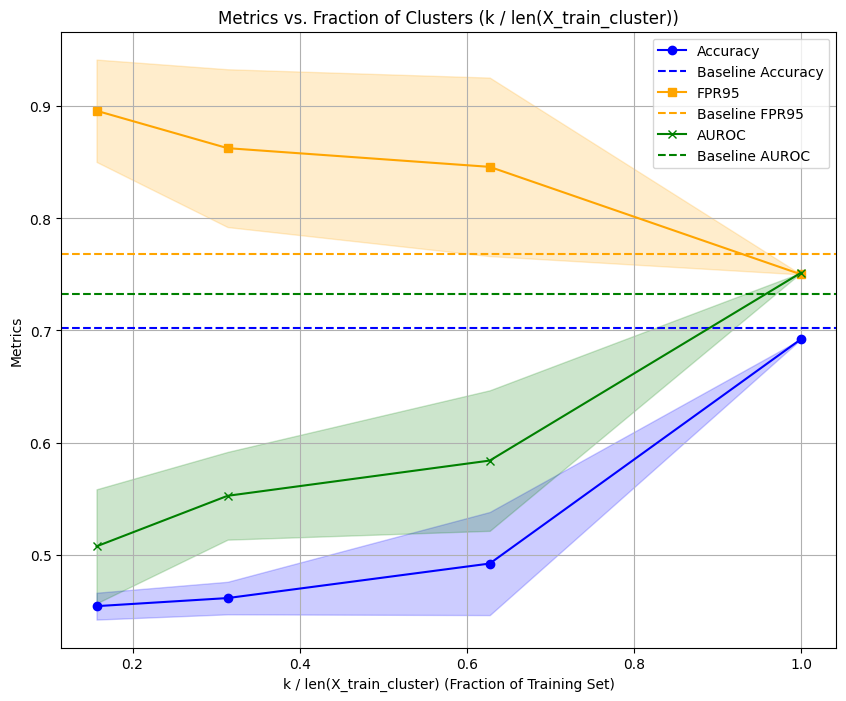

In [17]:
print("confidence_intervals_g", confidence_intervals_g)

df_results = benchmark_kmeans_with_varying_k_condidence_g_hat(
    X,
    y,
    M,
    test_size,
    n_runs=10,
    confidence_level=0.95,
    confidence_intervals_g=confidence_intervals_g,
    clf=None,
    save_plot=True,
    fname=cfg_dict["exp_name"],
)

### Feature Level Visualization: Understand how clustering alters the structure of the feature space

Proportion of label changes: 0.41


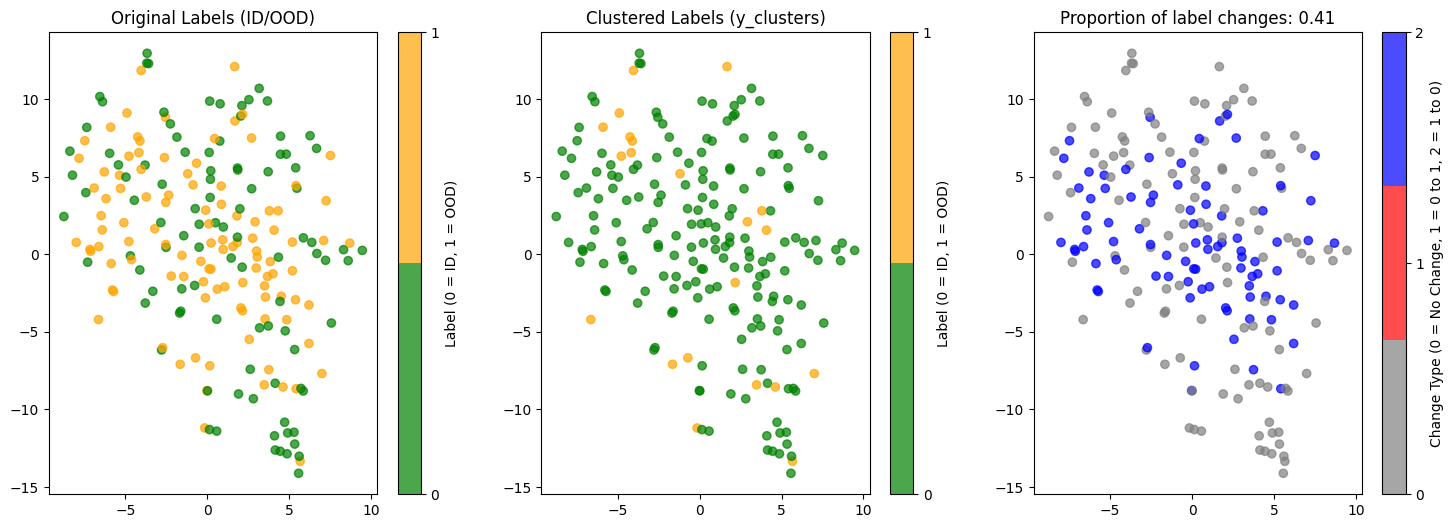

In [18]:
i = 0
_, X_train_cluster, y_train_cluster, y_clusters, *_ = run_g_hat_experiment(
    X, y, test_size, k, M, fixed_seed, fixed_seed, i + 1
)
plot_tsne_with_label_changes(
    X_train_cluster,
    y_train_cluster,
    y_clusters,
    class_name=cfg_dict["exp_name"],
    save_plot=True,
)

# Forest

### Start

In [ ]:
X,y,model,datamodule,train_dataloader,val_dataloader,test_dataloader,cfg_dict = get_X_y_arrays(
    paths["forest"]["config"],
    paths["forest"]["ckpt"],
    layer,
    downsample_method,
    getitem_keys,
    device,
    n_batches_to_process,
    mode="holdout",
    verbose=False)

### Downsample Benchmark

In [ ]:
for downsample in downsample_methods:
    print(f"Running experiments for {downsample} downsample method.")
    X, y, test_property_lengths = create_feature_matrix_and_labels(
        model=model,
        dm=datamodule,
        train_dataloader=train_dataloader,
        test_dataloader=test_dataloader,
        layer_names=layer,
        device=device,
        getitem_keys=getitem_keys,
        n_batches_to_process=n_batches_to_process,
        downsample_method=downsample,
        verbose=verbose,
    )
    print("Run g experiment for downsample method:", downsample)
    g_benchmark = run_g_experiment(
        X, y, split_seed, test_size, n_estimators, fixed_classifier_seed, clf=None
    )
    downsample_benchmark[downsample] = g_benchmark

In [ ]:
plot_downsample_benchmark(downsample_benchmark, datamodule.class_name)

### Layer Benchmark

In [ ]:
for lyr in selected_layers:
    print(f"Running experiments for layer {lyr}")
    X, y, test_property_lengths = create_feature_matrix_and_labels(
        model=model,
        dm=datamodule,
        train_dataloader=train_dataloader,
        test_dataloader=test_dataloader,
        layer_names=lyr,
        device=device,
        getitem_keys=getitem_keys,
        n_batches_to_process=n_batches_to_process,
        downsample_method=downsample_method,
        verbose=verbose,
    )

    g_benchmark = run_g_experiment(
        X, y, split_seed, test_size, n_estimators, fixed_classifier_seed, clf=None
    )
    layer_benchmark[str(lyr)] = g_benchmark

In [ ]:
plot_layer_benchmark(layer_benchmark, all_layer_names, datamodule.class_name)

### `g` confidence interval

In [ ]:
g_benchmark = run_multiple_experiments_g(
    X, y, test_size, n_estimators, random_seed=True
)

In [ ]:
columns_of_interest = ["baseline_accuracy", "baseline_fpr95", "baseline_roc_auc"]
confidence_intervals_g = calculate_confidence_intervals(
    g_benchmark, columns_of_interest
)
confidence_intervals_g

### `g_hat`

In [ ]:
results_df_g_hat = run_optuna_study(
    X,
    y,
    n_optuna_trials,
    test_size,
    min_cluster,
    max_cluster_ratio,
    min_fraction,
    max_fraction,
    n_estimators,
    fixed_seed
)

In [ ]:
N = 10
results_dict = results_df_g_hat.to_dict(orient="records")
k = int(len(X) * 0.3)
M = results_dict[0]["M"]
print("k, M, len(X), k/len(X)", k, M, len(X), k / len(X))

g_hat_benchmark = run_multiple_experiments_g_hat(X, y, test_size, k, M, N, fixed_seed)

### g g_hat mean std + ttest

In [ ]:
t_tests_results = perform_benchmark_analysis(g_benchmark, g_hat_benchmark)
t_tests_results

### Benchmark g

In [ ]:
classifier_benchmark_df = benchmark_classifiers(
    X, y, test_size, k, M, classifiers, fixed_seed
)

classifier_benchmark_df

### Benchmark clustering

In [ ]:
# A fixed classifier
classifier = classifiers['RandomForest']

clustering_benchmark_df = benchmark_clustering_methods(
    X, y, test_size, k, M, clustering_methods, classifier
)

clustering_benchmark_df

### Investigate k wrt g-g_hat

In [ ]:
print("confidence_intervals_g", confidence_intervals_g)

df_results = benchmark_kmeans_with_varying_k_condidence_g_hat(
    X,
    y,
    M,
    test_size,
    n_runs=10,
    confidence_level=0.95,
    confidence_intervals_g=confidence_intervals_g,
    clf=None,
    save_plot=True,
    fname=cfg_dict["data"]["class_name"],
)

### Feature Level Visualization: Understand how clustering alters the structure of the feature space

In [ ]:
i = 0
_, X_train_cluster, y_train_cluster, y_clusters, *_ = run_g_hat_experiment(
    X, y, test_size, k, M, fixed_seed, fixed_seed, i + 1
)
plot_tsne_with_label_changes(
    X_train_cluster,
    y_train_cluster,
    y_clusters,
    class_name=cfg_dict.data.class_name,
    save_plot=True,
)

# HerbaceousVegetation

### Start

In [ ]:
X,y,model,datamodule,train_dataloader,val_dataloader,test_dataloader,cfg_dict = get_X_y_arrays(
        paths["herb_veg"]["config"],
        paths["herb_veg"]["ckpt"],
        layer,
        downsample_method,
        getitem_keys,
        device,
        n_batches_to_process,
        mode="holdout",
        verbose=False,
    )

### Downsample Benchmark

In [ ]:
for downsample in downsample_methods:
    print(f"Running experiments for {downsample} downsample method.")
    X, y, test_property_lengths = create_feature_matrix_and_labels(
        model=model,
        dm=datamodule,
        train_dataloader=train_dataloader,
        test_dataloader=test_dataloader,
        layer_names=layer,
        device=device,
        getitem_keys=getitem_keys,
        n_batches_to_process=n_batches_to_process,
        downsample_method=downsample,
        verbose=verbose,
    )
    print("Run g experiment for downsample method:", downsample)
    g_benchmark = run_g_experiment(
        X, y, split_seed, test_size, n_estimators, fixed_classifier_seed, clf=None
    )
    downsample_benchmark[downsample] = g_benchmark

In [ ]:
plot_downsample_benchmark(downsample_benchmark, datamodule.class_name)

### Layer Benchmark

In [ ]:
for lyr in selected_layers:
    print(f"Running experiments for layer {lyr}")
    X, y, test_property_lengths = create_feature_matrix_and_labels(
        model=model,
        dm=datamodule,
        train_dataloader=train_dataloader,
        test_dataloader=test_dataloader,
        layer_names=lyr,
        device=device,
        getitem_keys=getitem_keys,
        n_batches_to_process=n_batches_to_process,
        downsample_method=downsample_method,
        verbose=verbose,
    )

    g_benchmark = run_g_experiment(
        X, y, split_seed, test_size, n_estimators, fixed_classifier_seed, clf=None
    )
    dict_key = datamodule.class_name + "_" + str(lyr)

    layer_benchmark[dict_key] = g_benchmark

In [ ]:
plot_layer_benchmark(layer_benchmark, all_layer_names, datamodule.class_name)

### g confidence interval

In [ ]:
g_benchmark = run_multiple_experiments_g(
    X, y, test_size, n_estimators, random_seed=True
)

In [ ]:
columns_of_interest = ["baseline_accuracy", "baseline_fpr95", "baseline_roc_auc"]
confidence_intervals_g = calculate_confidence_intervals(
    g_benchmark, columns_of_interest
)
confidence_intervals_g

### g_hat

In [ ]:
results_df_g_hat = run_optuna_study(
    X,
    y,
    n_optuna_trials,
    test_size,
    min_cluster,
    max_cluster_ratio,
    min_fraction,
    max_fraction,
    n_estimators,
    fixed_seed,
)

In [ ]:
N = 10
results_dict = results_df_g_hat.to_dict(orient="records")
k = int(len(X) * 0.3)
M = results_dict[0]["M"]
print("k, M, len(X), k/len(X)", k, M, len(X), k / len(X))

g_hat_benchmark = run_multiple_experiments_g_hat(X, y, test_size, k, M, N, fixed_seed)

### g g_hat mean std + ttest

In [ ]:
t_tests_results = perform_benchmark_analysis(g_benchmark, g_hat_benchmark)
t_tests_results

### Benchmark g

In [ ]:
classifier_benchmark_df = benchmark_classifiers(
    X, y, test_size, k, M, classifiers, fixed_seed
)

### Benchmark clustering

In [ ]:
# A fixed classifier
classifier = classifiers['RandomForest']

clustering_benchmark_df = benchmark_clustering_methods(
    X, y, test_size, k, M, clustering_methods, classifier
)

clustering_benchmark_df

### Investigate k wrt g-g_hat

In [ ]:
print("confidence_intervals_g: ", confidence_intervals_g)

df_results = benchmark_kmeans_with_varying_k_condidence_g_hat(
    X,
    y,
    M,
    test_size,
    n_runs=10,
    confidence_level=0.95,
    confidence_intervals_g=confidence_intervals_g,
    clf=None,
    save_plot=True,
    fname=cfg_dict["data"]["class_name"],
)

### Feature Level Visualization: Understand how clustering alters the structure of the feature space

In [ ]:
i = 0
_, X_train_cluster, y_train_cluster, y_clusters, *_ = run_g_hat_experiment(
    X, y, test_size, k, M, fixed_seed, fixed_seed, i + 1
)
plot_tsne_with_label_changes(
    X_train_cluster,
    y_train_cluster,
    y_clusters,
    class_name=cfg_dict.data.class_name,
    save_plot=True,
)

# Highway

### Start

In [ ]:
X,y,model,datamodule,train_dataloader,val_dataloader,test_dataloader,cfg_dict = get_X_y_arrays(
        paths["highway"]["config"],
        paths["highway"]["ckpt"],
        layer,
        downsample_method,
        getitem_keys,
        device,
        n_batches_to_process,
        mode="holdout",
        verbose=False,
    )

### Downsample Benchmark

In [ ]:
for downsample in downsample_methods:
    print(f"Running experiments for {downsample} downsample method.")
    X, y, test_property_lengths = create_feature_matrix_and_labels(
        model=model,
        dm=datamodule,
        train_dataloader=train_dataloader,
        test_dataloader=test_dataloader,
        layer_names=layer,
        device=device,
        getitem_keys=getitem_keys,
        n_batches_to_process=n_batches_to_process,
        downsample_method=downsample,
        verbose=verbose,
    )
    print("Run g experiment for downsample method:", downsample)
    g_benchmark = run_g_experiment(
        X, y, split_seed, test_size, n_estimators, fixed_classifier_seed, clf=None
    )
    downsample_benchmark[downsample] = g_benchmark

In [ ]:
plot_downsample_benchmark(downsample_benchmark, datamodule.class_name)

### Layer Benchmark

In [ ]:
for lyr in selected_layers:
    print(f"Running experiments for layer {lyr}")
    X, y, test_property_lengths = create_feature_matrix_and_labels(
        model=model,
        dm=datamodule,
        train_dataloader=train_dataloader,
        test_dataloader=test_dataloader,
        layer_names=lyr,
        device=device,
        getitem_keys=getitem_keys,
        n_batches_to_process=n_batches_to_process,
        downsample_method=downsample_method,
        verbose=verbose,
    )

    g_benchmark = run_g_experiment(
        X, y, split_seed, test_size, n_estimators, fixed_classifier_seed, clf=None
    )
    layer_benchmark[str(lyr)] = g_benchmark

In [ ]:
plot_layer_benchmark(layer_benchmark, all_layer_names, datamodule.class_name)

### g confidence interval

In [ ]:
g_benchmark = run_multiple_experiments_g(
    X, y, test_size, n_estimators, random_seed=True
)

In [ ]:
columns_of_interest = ["baseline_accuracy", "baseline_fpr95", "baseline_roc_auc"]
confidence_intervals_g = calculate_confidence_intervals(
    g_benchmark, columns_of_interest
)
confidence_intervals_g

### g_hat

In [ ]:
results_df_g_hat = run_optuna_study(
    X,
    y,
    n_optuna_trials,
    test_size,
    min_cluster,
    max_cluster_ratio,
    min_fraction,
    max_fraction,
    n_estimators,
    fixed_seed,
)

In [ ]:
N = 10
results_dict = results_df_g_hat.to_dict(orient="records")
k = int(len(X) * 0.3)
M = results_dict[0]["M"]
print("k, M, len(X), k/len(X)", k, M, len(X), k / len(X))

g_hat_benchmark = run_multiple_experiments_g_hat(X, y, test_size, k, M, N, fixed_seed)

### g g_hat mean std + ttest

In [ ]:
t_tests_results = perform_benchmark_analysis(g_benchmark, g_hat_benchmark)
t_tests_results

### Benchmark g

In [ ]:
classifier_benchmark_df = benchmark_classifiers(
    X, y, test_size, k, M, classifiers, fixed_seed
)

classifier_benchmark_df

### Benchmark clustering

In [ ]:
# A fixed classifier
classifier = classifiers['RandomForest']

clustering_benchmark_df = benchmark_clustering_methods(
    X, y, test_size, k, M, clustering_methods, classifier
)

clustering_benchmark_df

### Investigate k wrt g-g_hat

In [ ]:
print("confidence_intervals_g: ", confidence_intervals_g)

df_results = benchmark_kmeans_with_varying_k_condidence_g_hat(
    X,
    y,
    M,
    test_size,
    n_runs=10,
    confidence_level=0.95,
    confidence_intervals_g=confidence_intervals_g,
    clf=None,
    save_plot=True,
    fname=cfg_dict["data"]["class_name"],
)

### Feature Level Visualization: Understand how clustering alters the structure of the feature space

In [ ]:
i = 0
_, X_train_cluster, y_train_cluster, y_clusters, *_ = run_g_hat_experiment(
    X, y, test_size, k, M, fixed_seed, fixed_seed, i + 1
)
plot_tsne_with_label_changes(
    X_train_cluster,
    y_train_cluster,
    y_clusters,
    class_name=cfg_dict.data.class_name,
    save_plot=True,
)

# Industrial

### Start

In [ ]:
X,y,model,datamodule,train_dataloader,val_dataloader,test_dataloader,cfg_dict = get_X_y_arrays(
        paths["industrial"]["config"],
        paths["industrial"]["ckpt"],
        layer,
        downsample_method,
        getitem_keys,
        device,
        n_batches_to_process,
        mode="holdout",
        verbose=False,
    )

### Downsample Benchmark

In [ ]:
for downsample in downsample_methods:
    print(f"Running experiments for {downsample} downsample method.")
    X, y, test_property_lengths = create_feature_matrix_and_labels(
        model=model,
        dm=datamodule,
        train_dataloader=train_dataloader,
        test_dataloader=test_dataloader,
        layer_names=layer,
        device=device,
        getitem_keys=getitem_keys,
        n_batches_to_process=n_batches_to_process,
        downsample_method=downsample,
        verbose=verbose,
    )
    print("Run g experiment for downsample method:", downsample)
    g_benchmark = run_g_experiment(
        X, y, split_seed, test_size, n_estimators, fixed_classifier_seed, clf=None
    )
    downsample_benchmark[downsample] = g_benchmark

In [ ]:
plot_downsample_benchmark(downsample_benchmark, datamodule.class_name)

### Layer Benchmark

In [ ]:
for lyr in selected_layers:
    print(f"Running experiments for layer {lyr}")
    X, y, test_property_lengths = create_feature_matrix_and_labels(
        model=model,
        dm=datamodule,
        train_dataloader=train_dataloader,
        test_dataloader=test_dataloader,
        layer_names=lyr,
        device=device,
        getitem_keys=getitem_keys,
        n_batches_to_process=n_batches_to_process,
        downsample_method=downsample_method,
        verbose=verbose,
    )

    g_benchmark = run_g_experiment(
        X, y, split_seed, test_size, n_estimators, fixed_classifier_seed, clf=None
    )
    layer_benchmark[str(lyr)] = g_benchmark

In [ ]:
plot_layer_benchmark(layer_benchmark, all_layer_names, datamodule.class_name)

### g confidence interval

In [ ]:
g_benchmark = run_multiple_experiments_g(
    X, y, test_size, n_estimators, random_seed=True
)

In [ ]:
columns_of_interest = ["baseline_accuracy", "baseline_fpr95", "baseline_roc_auc"]
confidence_intervals_g = calculate_confidence_intervals(
    g_benchmark, columns_of_interest
)
confidence_intervals_g

### g_hat

In [ ]:
results_df_g_hat = run_optuna_study(
    X,
    y,
    n_optuna_trials,
    test_size,
    min_cluster,
    max_cluster_ratio,
    min_fraction,
    max_fraction,
    n_estimators,
    fixed_seed,
)

In [ ]:
N = 10
results_dict = results_df_g_hat.to_dict(orient="records")
k = int(len(X) * 0.3)
M = results_dict[0]["M"]
print("k, M, len(X), k/len(X)", k, M, len(X), k / len(X))

g_hat_benchmark = run_multiple_experiments_g_hat(X, y, test_size, k, M, N, fixed_seed)

### g g_hat mean std + ttest

In [ ]:
t_tests_results = perform_benchmark_analysis(g_benchmark, g_hat_benchmark)
t_tests_results

### Benchmark g

In [ ]:
classifier_benchmark_df = benchmark_classifiers(
    X, y, test_size, k, M, classifiers, fixed_seed
)

classifier_benchmark_df

### Benchmark clustering

In [ ]:
# A fixed classifier
classifier = classifiers['RandomForest']

clustering_benchmark_df = benchmark_clustering_methods(
    X, y, test_size, k, M, clustering_methods, classifier
)

clustering_benchmark_df

### Investigate k wrt g-g_hat

In [ ]:
print("confidence_intervals_g: ", confidence_intervals_g)

df_results = benchmark_kmeans_with_varying_k_condidence_g_hat(
    X,
    y,
    M,
    test_size,
    n_runs=10,
    confidence_level=0.95,
    confidence_intervals_g=confidence_intervals_g,
    clf=None,
    save_plot=True,
    fname=cfg_dict["data"]["class_name"],
)

### Feature Level Visualization: Understand how clustering alters the structure of the feature space

In [ ]:
i = 0
_, X_train_cluster, y_train_cluster, y_clusters, *_ = run_g_hat_experiment(
    X, y, test_size, k, M, fixed_seed, fixed_seed, i + 1
)
plot_tsne_with_label_changes(
    X_train_cluster,
    y_train_cluster,
    y_clusters,
    class_name=cfg_dict.data.class_name,
    save_plot=True,
)

# Pasture

### Start

In [ ]:
X,y,model,datamodule,train_dataloader,val_dataloader,test_dataloader,cfg_dict = get_X_y_arrays(
        paths["pasture"]["config"],
        paths["pasture"]["ckpt"],
        layer,
        downsample_method,
        getitem_keys,
        device,
        n_batches_to_process,
        mode="holdout",
        verbose=False,
    )

### Downsample Benchmark

In [ ]:
for downsample in downsample_methods:
    print(f"Running experiments for {downsample} downsample method.")
    X, y, test_property_lengths = create_feature_matrix_and_labels(
        model=model,
        dm=datamodule,
        train_dataloader=train_dataloader,
        test_dataloader=test_dataloader,
        layer_names=layer,
        device=device,
        getitem_keys=getitem_keys,
        n_batches_to_process=n_batches_to_process,
        downsample_method=downsample,
        verbose=verbose,
    )
    print("Run g experiment for downsample method:", downsample)
    g_benchmark = run_g_experiment(
        X, y, split_seed, test_size, n_estimators, fixed_classifier_seed, clf=None
    )
    downsample_benchmark[downsample] = g_benchmark

In [ ]:
plot_downsample_benchmark(downsample_benchmark, datamodule.class_name)

### Layer Benchmark

In [ ]:
for lyr in selected_layers:
    print(f"Running experiments for layer {lyr}")
    X, y, test_property_lengths = create_feature_matrix_and_labels(
        model=model,
        dm=datamodule,
        train_dataloader=train_dataloader,
        test_dataloader=test_dataloader,
        layer_names=lyr,
        device=device,
        getitem_keys=getitem_keys,
        n_batches_to_process=n_batches_to_process,
        downsample_method=downsample_method,
        verbose=verbose,
    )

    g_benchmark = run_g_experiment(
        X, y, split_seed, test_size, n_estimators, fixed_classifier_seed, clf=None
    )
    layer_benchmark[str(lyr)] = g_benchmark

In [ ]:
plot_layer_benchmark(layer_benchmark, all_layer_names, datamodule.class_name)

### g confidence interval

In [ ]:
g_benchmark = run_multiple_experiments_g(
    X, y, test_size, n_estimators, random_seed=True
)

In [ ]:
columns_of_interest = ["baseline_accuracy", "baseline_fpr95", "baseline_roc_auc"]
confidence_intervals_g = calculate_confidence_intervals(
    g_benchmark, columns_of_interest
)
confidence_intervals_g

### g_hat

In [ ]:
results_df_g_hat = run_optuna_study(
    X,
    y,
    n_optuna_trials,
    test_size,
    min_cluster,
    max_cluster_ratio,
    min_fraction,
    max_fraction,
    n_estimators,
    fixed_seed,
)

In [ ]:
N = 10
results_dict = results_df_g_hat.to_dict(orient="records")
k = int(len(X) * 0.3)
M = results_dict[0]["M"]
print("k, M, len(X), k/len(X)", k, M, len(X), k / len(X))

g_hat_benchmark = run_multiple_experiments_g_hat(X, y, test_size, k, M, N, fixed_seed)

### g g_hat mean std + ttest

In [ ]:
t_tests_results = perform_benchmark_analysis(g_benchmark, g_hat_benchmark)
t_tests_results

### Benchmark g

In [ ]:
classifiers = {
    "RandomForestUnblanaced": RandomForestClassifier(n_estimators=100, random_state=42),
    "RandomForest": RandomForestClassifier(
        n_estimators=100, class_weight="balanced", random_state=42
    ),
    "SVC": SVC(probability=True, class_weight="balanced", random_state=42),
    "KNeighbors": KNeighborsClassifier(),
    "LogisticRegression": LogisticRegression(
        class_weight="balanced", max_iter=500, random_state=42
    ),
    "DecisionTree": DecisionTreeClassifier(class_weight="balanced", random_state=42),
    "GradientBoosting": GradientBoostingClassifier(random_state=42),
    "AdaBoost": AdaBoostClassifier(random_state=42),
    "ExtraTrees": ExtraTreesClassifier(
        n_estimators=100, class_weight="balanced", random_state=42
    ),
    "GaussianNB": GaussianNB(),
}

classifier_benchmark_df = benchmark_classifiers(
    X, y, test_size, k, M, classifiers, fixed_seed
)

### Benchmark clustering

In [ ]:
clustering_methods = {
    "KMeans": KMeans(n_clusters=3, init="k-means++", random_state=42),
    "DBSCAN_eps_0.1": DBSCAN(eps=0.1, min_samples=5),
    "DBSCAN_eps_0.2": DBSCAN(eps=0.2, min_samples=5),
    "DBSCAN_eps_0.5": DBSCAN(eps=0.5, min_samples=5),
}

# A fixed classifier
classifier = RandomForestClassifier(
    n_estimators=100, class_weight="balanced", random_state=42
)

clustering_benchmark_df = benchmark_clustering_methods(
    X, y, test_size, k, M, clustering_methods, classifier
)

### Investigate k wrt g-g_hat

In [ ]:
print("confidence_intervals_g", confidence_intervals_g)

df_results = benchmark_kmeans_with_varying_k_condidence_g_hat(
    X,
    y,
    M,
    test_size,
    n_runs=10,
    confidence_level=0.95,
    confidence_intervals_g=confidence_intervals_g,
    clf=None,
    save_plot=True,
    fname=cfg_dict["data"]["class_name"],
)

### Feature Level Visualization: Understand how clustering alters the structure of the feature space

In [ ]:
i = 0
_, X_train_cluster, y_train_cluster, y_clusters, *_ = run_g_hat_experiment(
    X, y, test_size, k, M, fixed_seed, fixed_seed, i + 1
)
plot_tsne_with_label_changes(
    X_train_cluster,
    y_train_cluster,
    y_clusters,
    class_name=cfg_dict.data.class_name,
    save_plot=True,
)

# Permanent Crop

### Start

In [ ]:
X,y,model,datamodule,train_dataloader,val_dataloader,test_dataloader,cfg_dict = get_X_y_arrays(
        paths["permanentcrop"]["config"],
        paths["permanentcrop"]["ckpt"],
        layer,
        downsample_method,
        getitem_keys,
        device,
        n_batches_to_process,
        mode="holdout",
        verbose=False,
    )

### Downsample Benchmark

In [ ]:
for downsample in downsample_methods:
    print(f"Running experiments for {downsample} downsample method.")
    X, y, test_property_lengths = create_feature_matrix_and_labels(
        model=model,
        dm=datamodule,
        train_dataloader=train_dataloader,
        test_dataloader=test_dataloader,
        layer_names=collect_activations_from_layers,
        device=device,
        getitem_keys=getitem_keys,
        n_batches_to_process=n_batches_to_process,
        downsample_method=downsample,
        verbose=verbose,
    )
    print("Run g experiment for downsample method:", downsample)
    g_benchmark = run_g_experiment(
        X, y, split_seed, test_size, n_estimators, fixed_classifier_seed, clf=None
    )
    dict_key = datamodule.class_name + "_" + downsample
    downsample_benchmark[dict_key] = g_benchmark

In [ ]:
plot_downsample_benchmark(downsample_benchmark, datamodule.class_name)

### Layer Benchmark

In [ ]:
for lyr in selected_layers:
    print(f"Running experiments for layer {lyr}")
    X, y, test_property_lengths = create_feature_matrix_and_labels(
        model=model,
        dm=datamodule,
        train_dataloader=train_dataloader,
        test_dataloader=test_dataloader,
        layer_names=lyr,
        device=device,
        getitem_keys=getitem_keys,
        n_batches_to_process=n_batches_to_process,
        downsample_method=downsample_method,
        verbose=verbose,
    )

    g_benchmark = run_g_experiment(
        X, y, split_seed, test_size, n_estimators, fixed_classifier_seed, clf=None
    )
    layer_benchmark[str(lyr)] = g_benchmark

In [ ]:
plot_layer_benchmark(layer_benchmark, all_layer_names, datamodule.class_name)

### g confidence interval

In [ ]:
g_benchmark = run_multiple_experiments_g(
    X, y, test_size, n_estimators, random_seed=True
)

In [ ]:
columns_of_interest = ["baseline_accuracy", "baseline_fpr95", "baseline_roc_auc"]
confidence_intervals_g = calculate_confidence_intervals(
    g_benchmark, columns_of_interest
)
confidence_intervals_g

### g_hat

In [ ]:
results_df_g_hat = run_optuna_study(
    X,
    y,
    n_optuna_trials,
    test_size,
    min_cluster,
    max_cluster_ratio,
    min_fraction,
    max_fraction,
    n_estimators,
    fixed_seed,
)

In [ ]:
N = 10
results_dict = results_df_g_hat.to_dict(orient="records")
k = int(len(X) * 0.3)
M = results_dict[0]["M"]
print("k, M, len(X), k/len(X)", k, M, len(X), k / len(X))

g_hat_benchmark = run_multiple_experiments_g_hat(X, y, test_size, k, M, N, fixed_seed)

### g g_hat mean std + ttest

In [ ]:
t_tests_results = perform_benchmark_analysis(g_benchmark, g_hat_benchmark)
t_tests_results

### Benchmark g

In [ ]:
classifier_benchmark_df = benchmark_classifiers(
    X, y, test_size, k, M, classifiers, fixed_seed
)

### Benchmark clustering

In [ ]:
# A fixed classifier
classifier = classifiers['RandomForest']

clustering_benchmark_df = benchmark_clustering_methods(
    X, y, test_size, k, M, clustering_methods, classifier
)

clustering_benchmark_df

### Investigate k wrt g-g_hat

In [ ]:
print("confidence_intervals_g", confidence_intervals_g)

df_results = benchmark_kmeans_with_varying_k_condidence_g_hat(
    X,
    y,
    M,
    test_size,
    n_runs=10,
    confidence_level=0.95,
    confidence_intervals_g=confidence_intervals_g,
    clf=None,
    save_plot=True,
    fname=cfg_dict["data"]["class_name"],
)

### Feature Level Visualization: Understand how clustering alters the structure of the feature space

In [ ]:
i = 0
_, X_train_cluster, y_train_cluster, y_clusters, *_ = run_g_hat_experiment(
    X, y, test_size, k, M, fixed_seed, fixed_seed, i + 1
)
plot_tsne_with_label_changes(
    X_train_cluster,
    y_train_cluster,
    y_clusters,
    class_name=cfg_dict.data.class_name,
    save_plot=True,
)

# Residential

### Start

In [ ]:
X,y,model,datamodule,train_dataloader,val_dataloader,test_dataloader,cfg_dict = get_X_y_arrays(
        paths["residential"]["config"],
        paths["residential"]["ckpt"],
        layer,
        downsample_method,
        getitem_keys,
        device,
        n_batches_to_process,
        mode="holdout",
        verbose=False,
    )

### Downsample Benchmark

In [ ]:
for downsample in downsample_methods:
    print(f"Running experiments for {downsample} downsample method.")
    X, y, test_property_lengths = create_feature_matrix_and_labels(
        model=model,
        dm=datamodule,
        train_dataloader=train_dataloader,
        test_dataloader=test_dataloader,
        layer_names=layer,
        device=device,
        getitem_keys=getitem_keys,
        n_batches_to_process=n_batches_to_process,
        downsample_method=downsample,
        verbose=verbose,
    )
    print("Run g experiment for downsample method:", downsample)
    g_benchmark = run_g_experiment(
        X, y, split_seed, test_size, n_estimators, fixed_classifier_seed, clf=None
    )
    downsample_benchmark[downsample] = g_benchmark

In [ ]:
plot_downsample_benchmark(downsample_benchmark, datamodule.class_name)

### Layer Benchmark

In [ ]:
for lyr in selected_layers:
    print(f"Running experiments for layer {lyr}")
    X, y, test_property_lengths = create_feature_matrix_and_labels(
        model=model,
        dm=datamodule,
        train_dataloader=train_dataloader,
        test_dataloader=test_dataloader,
        layer_names=lyr,
        device=device,
        getitem_keys=getitem_keys,
        n_batches_to_process=n_batches_to_process,
        downsample_method=downsample_method,
        verbose=verbose,
    )

    g_benchmark = run_g_experiment(
        X, y, split_seed, test_size, n_estimators, fixed_classifier_seed, clf=None
    )
    layer_benchmark[str(lyr)] = g_benchmark

In [ ]:
plot_layer_benchmark(layer_benchmark, all_layer_names, datamodule.class_name)

### g confidence interval

In [ ]:
g_benchmark = run_multiple_experiments_g(
    X, y, test_size, n_estimators, random_seed=True
)

In [ ]:
columns_of_interest = ["baseline_accuracy", "baseline_fpr95", "baseline_roc_auc"]
confidence_intervals_g = calculate_confidence_intervals(
    g_benchmark, columns_of_interest
)
confidence_intervals_g

### g_hat

In [ ]:
results_df_g_hat = run_optuna_study(
    X,
    y,
    n_optuna_trials,
    test_size,
    min_cluster,
    max_cluster_ratio,
    min_fraction,
    max_fraction,
    n_estimators,
    fixed_seed,
)

In [ ]:
N = 10
results_dict = results_df_g_hat.to_dict(orient="records")
k = int(len(X) * 0.3)
M = results_dict[0]["M"]
print("k, M, len(X), k/len(X)", k, M, len(X), k / len(X))

g_hat_benchmark = run_multiple_experiments_g_hat(X, y, test_size, k, M, N, fixed_seed)

### g g_hat mean std + ttest

In [ ]:
t_tests_results = perform_benchmark_analysis(g_benchmark, g_hat_benchmark)
t_tests_results

### Benchmark g

In [ ]:
classifier_benchmark_df = benchmark_classifiers(
    X, y, test_size, k, M, classifiers, fixed_seed
)

### Benchmark clustering

In [ ]:
# A fixed classifier
classifier = classifiers['RandomForest']

clustering_benchmark_df = benchmark_clustering_methods(
    X, y, test_size, k, M, clustering_methods, classifier
)

clustering_benchmark_df

### Investigate k wrt g-g_hat

In [ ]:
print("confidence_intervals_g", confidence_intervals_g)

df_results = benchmark_kmeans_with_varying_k_condidence_g_hat(
    X,
    y,
    M,
    test_size,
    n_runs=10,
    confidence_level=0.95,
    confidence_intervals_g=confidence_intervals_g,
    clf=None,
    save_plot=True,
    fname=cfg_dict["data"]["class_name"],
)

### Feature Level Visualization: Understand how clustering alters the structure of the feature space

In [ ]:
i = 0
_, X_train_cluster, y_train_cluster, y_clusters, *_ = run_g_hat_experiment(
    X, y, test_size, k, M, fixed_seed, fixed_seed, i + 1
)
plot_tsne_with_label_changes(
    X_train_cluster,
    y_train_cluster,
    y_clusters,
    class_name=cfg_dict.data.class_name,
    save_plot=True,
)

# River

### Start

In [ ]:
X,y,model,datamodule,train_dataloader,val_dataloader,test_dataloader,cfg_dict = get_X_y_arrays(
        paths["river"]["config"],
        paths["river"]["ckpt"],
        layer,
        downsample_method,
        getitem_keys,
        device,
        n_batches_to_process,
        mode="holdout",
        verbose=False,
    )

### Downsample Benchmark

In [ ]:
for downsample in downsample_methods:
    print(f"Running experiments for {downsample} downsample method.")
    X, y, test_property_lengths = create_feature_matrix_and_labels(
        model=model,
        dm=datamodule,
        train_dataloader=train_dataloader,
        test_dataloader=test_dataloader,
        layer_names=layer,
        device=device,
        getitem_keys=getitem_keys,
        n_batches_to_process=n_batches_to_process,
        downsample_method=downsample,
        verbose=verbose,
    )
    print("Run g experiment for downsample method:", downsample)
    g_benchmark = run_g_experiment(
        X, y, split_seed, test_size, n_estimators, fixed_classifier_seed, clf=None
    )
    downsample_benchmark[downsample] = g_benchmark

In [ ]:
plot_downsample_benchmark(downsample_benchmark, datamodule.class_name)

### Layer Benchmark

In [ ]:
for lyr in selected_layers:
    print(f"Running experiments for layer {lyr}")
    X, y, test_property_lengths = create_feature_matrix_and_labels(
        model=model,
        dm=datamodule,
        train_dataloader=train_dataloader,
        test_dataloader=test_dataloader,
        layer_names=lyr,
        device=device,
        getitem_keys=getitem_keys,
        n_batches_to_process=n_batches_to_process,
        downsample_method=downsample_method,
        verbose=verbose,
    )

    g_benchmark = run_g_experiment(
        X, y, split_seed, test_size, n_estimators, fixed_classifier_seed, clf=None
    )
    layer_benchmark[str(lyr)] = g_benchmark

In [ ]:
plot_layer_benchmark(layer_benchmark, all_layer_names, datamodule.class_name)

### g confidence interval

In [ ]:
g_benchmark = run_multiple_experiments_g(
    X, y, test_size, n_estimators, random_seed=True
)

In [ ]:
columns_of_interest = ["baseline_accuracy", "baseline_fpr95", "baseline_roc_auc"]
confidence_intervals_g = calculate_confidence_intervals(
    g_benchmark, columns_of_interest
)
confidence_intervals_g

### g_hat

In [ ]:
results_df_g_hat = run_optuna_study(
    X,
    y,
    n_optuna_trials,
    test_size,
    min_cluster,
    max_cluster_ratio,
    min_fraction,
    max_fraction,
    n_estimators,
    fixed_seed,
)

In [ ]:
N = 10
results_dict = results_df_g_hat.to_dict(orient="records")
k = int(len(X) * 0.3)
M = results_dict[0]["M"]
print("k, M, len(X), k/len(X)", k, M, len(X), k / len(X))

g_hat_benchmark = run_multiple_experiments_g_hat(X, y, test_size, k, M, N, fixed_seed)

### g g_hat mean std + ttest

In [ ]:
t_tests_results = perform_benchmark_analysis(g_benchmark, g_hat_benchmark)
t_tests_results

### Benchmark g

In [ ]:
classifier_benchmark_df = benchmark_classifiers(
    X, y, test_size, k, M, classifiers, fixed_seed
)

### Benchmark clustering

In [ ]:
# A fixed classifier
classifier = classifiers['RandomForest']

clustering_benchmark_df = benchmark_clustering_methods(
    X, y, test_size, k, M, clustering_methods, classifier
)

clustering_benchmark_df

### Investigate k wrt g-g_hat

In [ ]:
print("confidence_intervals_g", confidence_intervals_g)

df_results = benchmark_kmeans_with_varying_k_condidence_g_hat(
    X,
    y,
    M,
    test_size,
    n_runs=10,
    confidence_level=0.95,
    confidence_intervals_g=confidence_intervals_g,
    clf=None,
    save_plot=True,
    fname=cfg_dict["data"]["class_name"],
)

### Feature Level Visualization: Understand how clustering alters the structure of the feature space

In [ ]:
i = 0
_, X_train_cluster, y_train_cluster, y_clusters, *_ = run_g_hat_experiment(
    X, y, test_size, k, M, fixed_seed, fixed_seed, i + 1
)
plot_tsne_with_label_changes(
    X_train_cluster,
    y_train_cluster,
    y_clusters,
    class_name=cfg_dict.data.class_name,
    save_plot=True,
)

# SeaLake

### Start

In [ ]:
X,y,model,datamodule,train_dataloader,val_dataloader,test_dataloader,cfg_dict = get_X_y_arrays(
        paths["sealake"]["config"],
        paths["sealake"]["ckpt"],
        layer,
        downsample_method,
        getitem_keys,
        device,
        n_batches_to_process,
        mode="holdout",
        verbose=False,
    )

### Downsample Benchmark

In [ ]:
for downsample in downsample_methods:
    print(f"Running experiments for {downsample} downsample method.")
    X, y, test_property_lengths = create_feature_matrix_and_labels(
        model=model,
        dm=datamodule,
        train_dataloader=train_dataloader,
        test_dataloader=test_dataloader,
        layer_names=layer,
        device=device,
        getitem_keys=getitem_keys,
        n_batches_to_process=n_batches_to_process,
        downsample_method=downsample,
        verbose=verbose,
    )
    print("Run g experiment for downsample method:", downsample)
    g_benchmark = run_g_experiment(
        X, y, split_seed, test_size, n_estimators, fixed_classifier_seed, clf=None
    )
    downsample_benchmark[downsample] = g_benchmark

In [ ]:
plot_downsample_benchmark(downsample_benchmark, datamodule.class_name)

### Layer Benchmark

In [ ]:
for lyr in selected_layers:
    print(f"Running experiments for layer {lyr}")
    X, y, test_property_lengths = create_feature_matrix_and_labels(
        model=model,
        dm=datamodule,
        train_dataloader=train_dataloader,
        test_dataloader=test_dataloader,
        layer_names=lyr,
        device=device,
        getitem_keys=getitem_keys,
        n_batches_to_process=n_batches_to_process,
        downsample_method=downsample_method,
        verbose=verbose,
    )

    g_benchmark = run_g_experiment(
        X, y, split_seed, test_size, n_estimators, fixed_classifier_seed, clf=None
    )
    layer_benchmark[str(lyr)] = g_benchmark

In [ ]:
plot_layer_benchmark(layer_benchmark, all_layer_names, datamodule.class_name)

### g confidence interval

In [ ]:
g_benchmark = run_multiple_experiments_g(
    X, y, test_size, n_estimators, random_seed=True
)

In [ ]:
columns_of_interest = ["baseline_accuracy", "baseline_fpr95", "baseline_roc_auc"]
confidence_intervals_g = calculate_confidence_intervals(
    g_benchmark, columns_of_interest
)
confidence_intervals_g

### g_hat

In [ ]:
results_df_g_hat = run_optuna_study(
    X,
    y,
    n_optuna_trials,
    test_size,
    min_cluster,
    max_cluster_ratio,
    min_fraction,
    max_fraction,
    n_estimators,
    fixed_seed,
)

In [ ]:
N = 10
results_dict = results_df_g_hat.to_dict(orient="records")
k = int(len(X) * 0.3)
M = results_dict[0]["M"]
print("k, M, len(X), k/len(X)", k, M, len(X), k / len(X))

g_hat_benchmark = run_multiple_experiments_g_hat(X, y, test_size, k, M, N, fixed_seed)

### g g_hat mean std + ttest

In [ ]:
t_tests_results = perform_benchmark_analysis(g_benchmark, g_hat_benchmark)
t_tests_results

### Benchmark g

In [ ]:
classifier_benchmark_df = benchmark_classifiers(
    X, y, test_size, k, M, classifiers, fixed_seed
)

classifier_benchmark_df

### Benchmark clustering

In [ ]:
# A fixed classifier
classifier = classifiers['RandomForest']

clustering_benchmark_df = benchmark_clustering_methods(
    X, y, test_size, k, M, clustering_methods, classifier
)

clustering_benchmark_df

### Investigate k wrt g-g_hat

In [ ]:
print("confidence_intervals_g", confidence_intervals_g)

df_results = benchmark_kmeans_with_varying_k_condidence_g_hat(
    X,
    y,
    M,
    test_size,
    n_runs=10,
    confidence_level=0.95,
    confidence_intervals_g=confidence_intervals_g,
    clf=None,
)

### Feature Level Visualization: Understand how clustering alters the structure of the feature space

In [ ]:
i = 0
_, X_train_cluster, y_train_cluster, y_clusters, *_ = run_g_hat_experiment(
    X, y, test_size, k, M, fixed_seed, fixed_seed, i + 1
)
plot_tsne_with_label_changes(
    X_train_cluster,
    y_train_cluster,
    y_clusters,
    class_name=cfg_dict.data.class_name,
    save_plot=True,
)

# Annual Crop

### Start

In [ ]:
X,y,model,datamodule,train_dataloader,val_dataloader,test_dataloader,cfg_dict = get_X_y_arrays(
        paths["annualcrop"]["config"],
        paths["annualcrop"]["ckpt"],
        layer,
        downsample_method,
        getitem_keys,
        device,
        n_batches_to_process,
        mode="holdout",
        verbose=False,
    )

### Downsample Benchmark

In [ ]:
for downsample in downsample_methods:
    print(f"Running experiments for {downsample} downsample method.")
    X, y, test_property_lengths = create_feature_matrix_and_labels(
        model=model,
        dm=datamodule,
        train_dataloader=train_dataloader,
        test_dataloader=test_dataloader,
        layer_names=layer,
        device=device,
        getitem_keys=getitem_keys,
        n_batches_to_process=n_batches_to_process,
        downsample_method=downsample,
        verbose=verbose,
    )
    print("Run g experiment for downsample method:", downsample)
    g_benchmark = run_g_experiment(
        X, y, split_seed, test_size, n_estimators, fixed_classifier_seed, clf=None
    )
    downsample_benchmark[downsample] = g_benchmark

In [ ]:
downsample_benchmark

In [ ]:
plot_downsample_benchmark(downsample_benchmark, datamodule.class_name)

### Layer Benchmark

In [ ]:
for lyr in selected_layers:
    print(f"Running experiments for layer {lyr}")
    X, y, test_property_lengths = create_feature_matrix_and_labels(
        model=model,
        dm=datamodule,
        train_dataloader=train_dataloader,
        test_dataloader=test_dataloader,
        layer_names=lyr,
        device=device,
        getitem_keys=getitem_keys,
        n_batches_to_process=n_batches_to_process,
        downsample_method=downsample_method,
        verbose=verbose,
    )

    g_benchmark = run_g_experiment(
        X, y, split_seed, test_size, n_estimators, fixed_classifier_seed, clf=None
    )
    layer_benchmark[str(lyr)] = g_benchmark

In [ ]:
plot_layer_benchmark(layer_benchmark, all_layer_names, datamodule.class_name)

### g confidence interval

In [ ]:
g_benchmark = run_multiple_experiments_g(
    X, y, test_size, n_estimators, random_seed=True
)

In [ ]:
columns_of_interest = ["baseline_accuracy", "baseline_fpr95", "baseline_roc_auc"]
confidence_intervals_g = calculate_confidence_intervals(
    g_benchmark, columns_of_interest
)
confidence_intervals_g

### g_hat

In [ ]:
results_df_g_hat = run_optuna_study(
    X,
    y,
    n_optuna_trials,
    test_size,
    min_cluster,
    max_cluster_ratio,
    min_fraction,
    max_fraction,
    n_estimators,
    fixed_seed,
)

In [ ]:
N = 10
results_dict = results_df_g_hat.to_dict(orient="records")
k = int(len(X) * 0.3)
M = results_dict[0]["M"]
print("k, M, len(X), k/len(X)", k, M, len(X), k / len(X))

g_hat_benchmark = run_multiple_experiments_g_hat(X, y, test_size, k, M, N, fixed_seed)

### g g_hat mean std + ttest

In [ ]:
t_tests_results = perform_benchmark_analysis(g_benchmark, g_hat_benchmark)
t_tests_results

### Benchmark g

In [ ]:
classifier_benchmark_df = benchmark_classifiers(
    X, y, test_size, k, M, classifiers, fixed_seed
)

classifier_benchmark_df

### Benchmark clustering

In [ ]:
# A fixed classifier
classifier = classifiers['RandomForest']

clustering_benchmark_df = benchmark_clustering_methods(
    X, y, test_size, k, M, clustering_methods, classifier
)

clustering_benchmark_df

### Investigate k wrt g-g_hat

In [ ]:
print("confidence_intervals_g", confidence_intervals_g)

df_results = benchmark_kmeans_with_varying_k_condidence_g_hat(
    X,
    y,
    M,
    test_size,
    n_runs=10,
    confidence_level=0.95,
    confidence_intervals_g=confidence_intervals_g,
    clf=None,
)

### Feature Level Visualization: Understand how clustering alters the structure of the feature space

In [ ]:
i = 0
_, X_train_cluster, y_train_cluster, y_clusters, *_ = run_g_hat_experiment(
    X, y, test_size, k, M, fixed_seed, fixed_seed, i + 1
)
plot_tsne_with_label_changes(
    X_train_cluster,
    y_train_cluster,
    y_clusters,
    class_name=cfg_dict.data.class_name,
    save_plot=True,
)